In [53]:
!pip install tensorly

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, Reshape, Dropout
import tensorly as tl
from tensorly.decomposition import tucker
from tensorflow.keras.callbacks import LearningRateScheduler

True


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:



stock_symbols = [
    "RELIANCE", "TCS", "HDFCBANK", "BHARTIARTL", "ICICIBANK",
    "INFY", "HINDUNILVR", "SBIN", "ITC"
]
# stock_symbols = ["RELIANCE"]
# Load all fundamental and sentiment CSV files using STOCK_NAMES array
fundamental_files = [f"/content/drive/MyDrive/Dataset/{name}.NS_financial_data.csv" for name in stock_symbols]
sentiment_files = [f"/content/drive/MyDrive/Dataset/{name}_sentiment.csv" for name in stock_symbols]

# Load data into dictionaries for easy access by stock symbol
fundamental_data = {os.path.basename(f).split('.')[0]: pd.read_csv(f) for f in fundamental_files}
sentiment_data = {os.path.basename(s).split('_')[0]: pd.read_csv(s) for s in sentiment_files}


In [37]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for symbol, data in fundamental_data.items():
    # Remove the Symbol column
    fundamental_data[symbol] = data.drop(columns=['Symbol'])
    # Normalize the data
    fundamental_data[symbol].iloc[:, 1:] = scaler.fit_transform(fundamental_data[symbol].iloc[:, 1:])
    fundamental_data[symbol].iloc[:, 1:] = scaler.transform(fundamental_data[symbol].iloc[:, 1:])
    # print(fundamental_data[symbol].head())

for symbol, data in sentiment_data.items():
    sentiment_data[symbol].iloc[:, 1:] = scaler.fit_transform(sentiment_data[symbol].iloc[:, 1:])
    sentiment_data[symbol].iloc[:, 1:] = scaler.transform(sentiment_data[symbol].iloc[:, 1:])
    # print(sentiment_data[symbol].head())

                          Date  Opening Price  Highest Price  Lowest Price  \
259  2021-01-01 00:00:00+05:30      -1.794266      -1.931374     -1.826937   
260  2021-01-04 00:00:00+05:30      -1.794261      -1.931372     -1.826967   
261  2021-01-05 00:00:00+05:30      -1.794293      -1.931402     -1.826991   
262  2021-01-06 00:00:00+05:30      -1.794301      -1.931436     -1.827096   
263  2021-01-07 00:00:00+05:30      -1.794390      -1.931484     -1.827094   

     Closing Price  Volume of Trade  P/E Ratio  P/B Ratio  Target1  Target2  \
259      -1.784940        -0.006596  -1.660999  -1.788042        1        1   
260      -1.784933        -0.006596  -1.660738  -1.783888        0        0   
261      -1.784981        -0.006596  -1.662572  -1.813145        0        0   
262      -1.785080        -0.006596  -1.666430  -1.874684        0        0   
263      -1.785086        -0.006596  -1.666664  -1.878423        0        1   

     Target3  
259        1  
260        0  
261        

<ipython-input-37-fe0c9856c9c5>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01790904 0.04714187 0.04600699 0.12765664 0.08118864 0.03998687
 0.05797484 0.07075002 0.06719824 0.27772097 0.19017581 0.20526272
 0.08537514 0.06931806 0.23347674 0.07232711 0.20246824 0.26378946
 0.31494024 0.13741065 0.12058227 0.16260024 0.13659196 0.24496338
 0.04343782 0.10251537 0.08696668 0.06658511 0.29524855 0.09294346
 0.04402359 0.04956764 0.10100059 0.03979016 0.05534895 0.09424661
 0.05880502 0.23905606 0.36651366 0.13364864 0.0503812  0.03532148
 0.16449243 0.19798947 0.06028593 0.05167814 0.04192614 0.03212396
 0.03975023 0.0731298  0.02807045 0.03119138 0.14494012 0.10672969
 0.04268004 0.08333565 0.04119338 0.04151221 0.1177303  0.03473602
 0.02570715 0.03171904 0.03277126 0.04585441 0.03714656 0.23190665
 0.03087503 0.09690125 0.03465414 0.0444832  0.22559861 0.06890211
 0.05783282 0.17675115 0.05090047 0.2001534

In [55]:
# Prepare data for each stock
# Forecast horizon and sequence length
k = 1
sequence_length = 5

# Tucker decomposition ranks
rank_time, rank_fund, rank_sentiment = 5, 7, 3
X_dict, y_dict = {}, {}  # Dictionary to hold data per stock
for symbol in stock_symbols:
    fund_data = fundamental_data[symbol]
    sent_data = sentiment_data[symbol]

    # Date alignment
    sent_data['date'] = pd.to_datetime(sent_data['date'], errors='coerce')
    fund_data['Date'] = pd.to_datetime(fund_data['Date'], errors='coerce')
    sent_data['date'] = sent_data['date'].dt.tz_localize(None)
    fund_data['Date'] = fund_data['Date'].dt.tz_localize(None)

    # Merge and fill missing values
    merged_data = pd.merge(fund_data, sent_data, how='left', left_on='Date', right_on='date').fillna(0)
    fund_columns = ['Opening Price', 'Highest Price', 'Lowest Price', 'Closing Price', 'Volume of Trade', 'P/E Ratio', 'P/B Ratio']
    sentiment_columns = ['Pt_plus', 'Pt_minus', 'Dt']

    # Scale data
    scaler = MinMaxScaler()
    numeric_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
    merged_data[numeric_cols] = scaler.fit_transform(merged_data[numeric_cols])

    # Create target labels
    merged_data['Target1'] = (merged_data['Opening Price'].shift(-k) - merged_data['Opening Price']).apply(lambda x: 1 if x > 0 else 0)
    merged_data['Target2'] = (merged_data['Closing Price'].shift(-k) - merged_data['Closing Price']).apply(lambda x: 1 if x > 0 else 0)
    merged_data['Target3'] = (merged_data['Closing Price'].shift(-k) - merged_data['Opening Price']).apply(lambda x: 1 if x > 0 else 0)
    merged_data.dropna(inplace=True)

    # Prepare rolling windows and create tensors
    X, y1, y2, y3 = [], [], [], []

    for i in range(len(merged_data) - sequence_length):
        fund_values = merged_data[fund_columns].iloc[i:i+sequence_length].values
        sentiment_values = merged_data[sentiment_columns].iloc[i:i+sequence_length].values
        tensor = np.einsum('ij,ik->ijk', fund_values, sentiment_values)

        # Tucker decomposition
        core, factors = tucker(tensor, rank=[rank_time, rank_fund, rank_sentiment])
        decomposed_tensor = tl.tucker_to_tensor((core, factors))

        X.append(decomposed_tensor)
        y1.append(merged_data['Target1'].iloc[i + sequence_length - 1])
        y2.append(merged_data['Target2'].iloc[i + sequence_length - 1])
        y3.append(merged_data['Target3'].iloc[i + sequence_length - 1])

    # Store data for each stock in dictionaries
    X_dict[symbol] = np.array(X)
    y_dict[symbol] = [np.array(y1), np.array(y2), np.array(y3)]


In [5]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.4 MB/s eta 0:00:00


In [64]:
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, Reshape, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef

# Model Definition
def create_lstm_model(input_shape):
    tensor_input = Input(shape=input_shape)
    reshaped_input = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(tensor_input)
    conv_layer = Conv1D(16, 2, activation='relu')(reshaped_input)
    reshaped_for_lstm = Reshape((conv_layer.shape[1], conv_layer.shape[2]))(conv_layer)
    lstm_out = LSTM(32)(reshaped_for_lstm)
    lstm_out = Dropout(0.3)(lstm_out)
    output = Dense(1, activation='sigmoid')(lstm_out)
    model = Model(inputs=tensor_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training Function for Each Target
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, matthews_corrcoef

def train_and_evaluate(X, y, target_name, callbacks=None):
    # Split data into training and testing sets (80% - 20%)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create and compile the model
    model = create_lstm_model(X_train.shape[1:])

    # Define ModelCheckpoint to save the best model based on validation accuracy
    if callbacks is None:
        callbacks = []

    # Train the model with the given callbacks (e.g., ModelCheckpoint)
    history = model.fit(X_train, y_train, epochs=20, batch_size=8,
                        validation_data=(X_test, y_test),
                        verbose=1, callbacks=callbacks)

    # Print accuracy after each epoch
    print(f"\nAccuracy after each epoch for {target_name}:")
    for epoch in range(len(history.history['accuracy'])):
        print(f"Epoch {epoch + 1}: Accuracy = {history.history['accuracy'][epoch]:.4f}")

    # Make predictions and calculate accuracy metrics
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    da = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    return history, da, mcc



In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Store results for each stock and target
results = {symbol: {} for symbol in stock_symbols}

for symbol in stock_symbols:
    X = X_dict[symbol]

    # Define the path for saving the best model
    model_save_path = f"best_model_{symbol}.keras"

    # Define a ModelCheckpoint callback to save the best model based on validation accuracy
    checkpoint_callback = ModelCheckpoint(model_save_path,
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          mode='max',
                                          verbose=1)

    for i, target_name in enumerate(['Target1', 'Target2', 'Target3']):
        history, da, mcc = train_and_evaluate(X, y_dict[symbol][i], target_name, callbacks=[checkpoint_callback])

        # Store results
        results[symbol][target_name] = {'DA': da, 'MCC': mcc, 'history': history}

        # Print accuracy after each epoch (from history object)
        print(f"\nResults for {symbol} - {target_name}:")
        for epoch in range(len(history.history['accuracy'])):
            print(f"Epoch {epoch + 1}: Accuracy = {history.history['accuracy'][epoch]:.4f}")

# Display results
for symbol, target_results in results.items():
    print(f"\nResults for {symbol}:")
    for target, metrics in target_results.items():
        print(f"{target} - DA: {metrics['DA']:.4f}, MCC: {metrics['MCC']:.4f}")


Epoch 1/20
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4980 - loss: 0.6988
Epoch 1: val_accuracy improved from -inf to 0.43434, saving model to best_model_RELIANCE.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4982 - loss: 0.6987 - val_accuracy: 0.4343 - val_loss: 0.7164
Epoch 2/20
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5249 - loss: 0.6947
Epoch 2: val_accuracy improved from 0.43434 to 0.49495, saving model to best_model_RELIANCE.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5241 - loss: 0.6947 - val_accuracy: 0.4949 - val_loss: 0.6940
Epoch 3/20
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5316 - loss: 0.6913
Epoch 3: val_accuracy improved from 0.49495 to 0.54040, saving model to best_model_RELIANCE.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5324 - loss: 0.6912 - val_accuracy: 0.5404 - val_loss: 0.6894
Epoch 4/20
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5967 - loss: 0.6816
Epoch 4: val_accuracy did n

In [52]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, Reshape, Dropout
import tensorly as tl
from tensorly.decomposition import tucker
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Stock symbols and file paths
stock_symbols = [
    "RELIANCE", "TCS", "HDFCBANK", "BHARTIARTL", "ICICIBANK",
    "INFY", "HINDUNILVR", "SBIN", "ITC"
]
fundamental_files = [f"/content/drive/MyDrive/Dataset/{name}.NS_financial_data.csv" for name in stock_symbols]
sentiment_files = [f"/content/drive/MyDrive/Dataset/{name}_sentiment.csv" for name in stock_symbols]

# Load the data
fundamental_data = {os.path.basename(f).split('.')[0]: pd.read_csv(f) for f in fundamental_files}
sentiment_data = {os.path.basename(s).split('_')[0]: pd.read_csv(s) for s in sentiment_files}

# Forecast horizon and sequence length
k = 1
sequence_length = 5

# Tucker decomposition ranks
rank_time, rank_fund, rank_sentiment = 5, 7, 3

# Loop over each stock for separate processing
results = {}
for symbol in stock_symbols:
    fund_data = fundamental_data[symbol]
    sent_data = sentiment_data[symbol]

    # Prepare data for date alignment
    sent_data['date'] = pd.to_datetime(sent_data['date'], errors='coerce')
    fund_data['Date'] = pd.to_datetime(fund_data['Date'], errors='coerce')
    sent_data['date'] = sent_data['date'].dt.tz_localize(None)
    fund_data['Date'] = fund_data['Date'].dt.tz_localize(None)

    # Merge and fill missing values
    merged_data = pd.merge(fund_data, sent_data, how='left', left_on='Date', right_on='date').fillna(0)
    fund_columns = ['Opening Price', 'Highest Price', 'Lowest Price', 'Closing Price', 'Volume of Trade', 'P/E Ratio', 'P/B Ratio']
    sentiment_columns = ['Pt_plus', 'Pt_minus', 'Dt']

    # Scaling data
    scaler = MinMaxScaler()
    numeric_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
    merged_data[numeric_cols] = scaler.fit_transform(merged_data[numeric_cols])

    # Create target labels
    merged_data['Target1'] = (merged_data['Opening Price'].shift(-k) - merged_data['Opening Price']).apply(lambda x: 1 if x > 0 else 0)
    merged_data['Target2'] = (merged_data['Closing Price'].shift(-k) - merged_data['Closing Price']).apply(lambda x: 1 if x > 0 else 0)
    merged_data['Target3'] = (merged_data['Closing Price'].shift(-k) - merged_data['Opening Price']).apply(lambda x: 1 if x > 0 else 0)
    merged_data.dropna(inplace=True)

    # Prepare rolling windows for each stock and target
    X, y1, y2, y3 = [], [], [], []

    for i in range(len(merged_data) - sequence_length):
        fund_values = merged_data[fund_columns].iloc[i:i+sequence_length].values
        sentiment_values = merged_data[sentiment_columns].iloc[i:i+sequence_length].values
        tensor = np.einsum('ij,ik->ijk', fund_values, sentiment_values)

        # Tucker decomposition
        core, factors = tucker(tensor, rank=[rank_time, rank_fund, rank_sentiment])
        decomposed_tensor = tl.tucker_to_tensor((core, factors))

        X.append(decomposed_tensor)
        y1.append(merged_data['Target1'].iloc[i + sequence_length - 1])
        y2.append(merged_data['Target2'].iloc[i + sequence_length - 1])
        y3.append(merged_data['Target3'].iloc[i + sequence_length - 1])

    # Convert to numpy arrays
    X = np.array(X)
    y1, y2, y3 = np.array(y1), np.array(y2), np.array(y3)

    # Train-test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y1_train, y1_test = y1[:train_size], y1[train_size:]
    y2_train, y2_test = y2[:train_size], y2[train_size:]
    y3_train, y3_test = y3[:train_size], y3[train_size:]

    # Model Definition
    def create_lstm_model(input_shape):
        tensor_input = Input(shape=input_shape)
        reshaped_input = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(tensor_input)
        conv_layer = Conv1D(16, 2, activation='relu')(reshaped_input)
        reshaped_for_lstm = Reshape((conv_layer.shape[1], conv_layer.shape[2]))(conv_layer)
        lstm_out = LSTM(32)(reshaped_for_lstm)
        lstm_out = Dropout(0.3)(lstm_out)
        output = Dense(1, activation='sigmoid')(lstm_out)
        model = Model(inputs=tensor_input, outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Define input shape and compile models for each target
    input_shape = (sequence_length, rank_fund, rank_sentiment)
    model1, model2, model3 = create_lstm_model(input_shape), create_lstm_model(input_shape), create_lstm_model(input_shape)

    # Train models and record accuracy
    history1 = model1.fit(X_train, y1_train, epochs=10, batch_size=16, validation_data=(X_test, y1_test), verbose=0)
    history2 = model2.fit(X_train, y2_train, epochs=10, batch_size=16, validation_data=(X_test, y2_test), verbose=0)
    history3 = model3.fit(X_train, y3_train, epochs=10, batch_size=16, validation_data=(X_test, y3_test), verbose=0)

    # Record results for each target
    results[symbol] = {
        'Target1_Accuracy': history1.history['val_accuracy'][-1],
        'Target2_Accuracy': history2.history['val_accuracy'][-1],
        'Target3_Accuracy': history3.history['val_accuracy'][-1],
    }

# Display results
for symbol, result in results.items():
    print(f"\nResults for {symbol}:")
    print(f"Target1 Accuracy: {result['Target1_Accuracy']:.4f}")
    print(f"Target2 Accuracy: {result['Target2_Accuracy']:.4f}")
    print(f"Target3 Accuracy: {result['Target3_Accuracy']:.4f}")



Results for RELIANCE:
Target1 Accuracy: 0.5404
Target2 Accuracy: 0.4949
Target3 Accuracy: 0.5455

Results for TCS:
Target1 Accuracy: 0.5152
Target2 Accuracy: 0.5101
Target3 Accuracy: 0.5556

Results for HDFCBANK:
Target1 Accuracy: 0.5253
Target2 Accuracy: 0.4747
Target3 Accuracy: 0.6010

Results for BHARTIARTL:
Target1 Accuracy: 0.4949
Target2 Accuracy: 0.4899
Target3 Accuracy: 0.5101

Results for ICICIBANK:
Target1 Accuracy: 0.5707
Target2 Accuracy: 0.5404
Target3 Accuracy: 0.7273

Results for INFY:
Target1 Accuracy: 0.5606
Target2 Accuracy: 0.4848
Target3 Accuracy: 0.6061

Results for HINDUNILVR:
Target1 Accuracy: 0.5657
Target2 Accuracy: 0.5505
Target3 Accuracy: 0.5606

Results for SBIN:
Target1 Accuracy: 0.5202
Target2 Accuracy: 0.5707
Target3 Accuracy: 0.9646

Results for ITC:
Target1 Accuracy: 0.5556
Target2 Accuracy: 0.5152
Target3 Accuracy: 0.5606


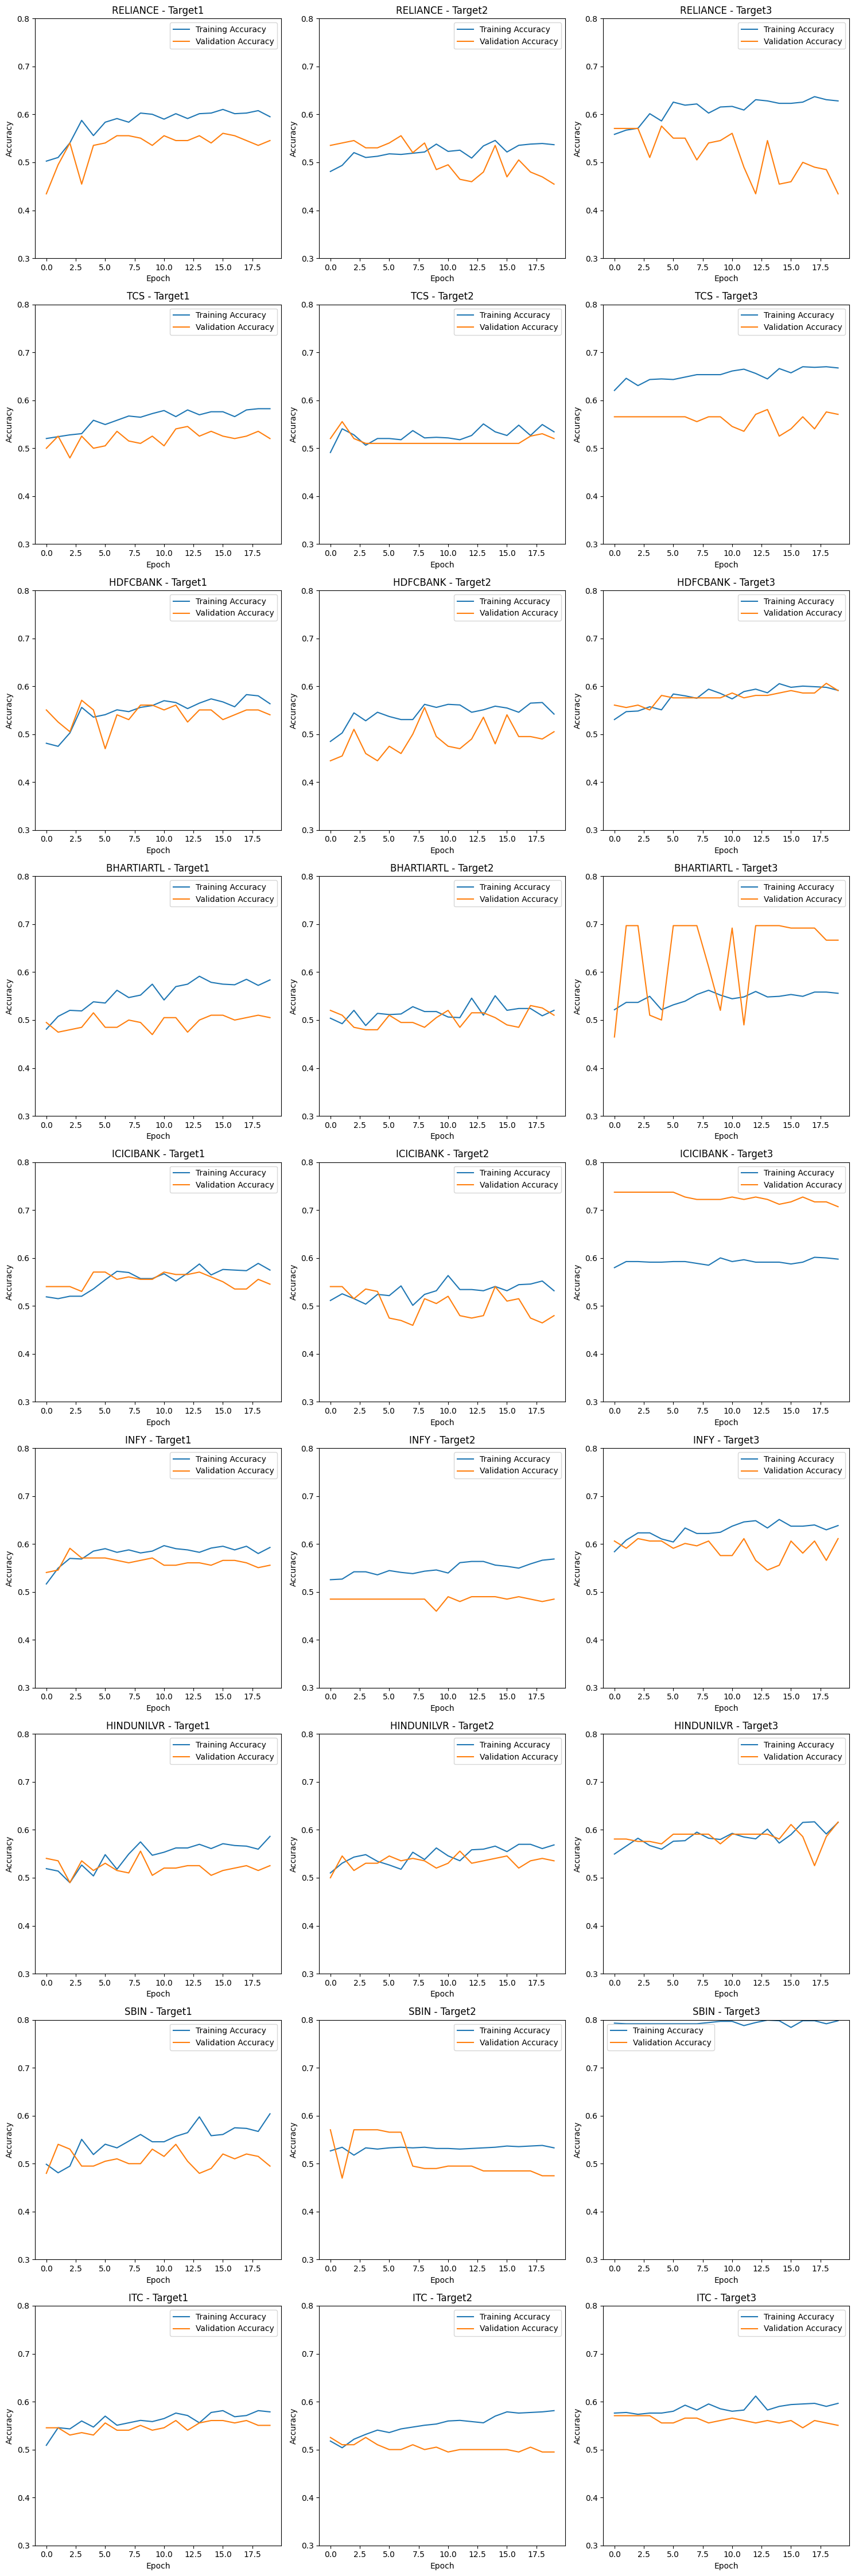

In [69]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Accuracy for each stock and target
fig, axes = plt.subplots(len(stock_symbols), 3, figsize=(15, 5 * len(stock_symbols)))
for i, symbol in enumerate(stock_symbols):
    for j, target in enumerate(['Target1', 'Target2', 'Target3']):
        history = results[symbol][target]['history']
        ax = axes[i, j] if len(stock_symbols) > 1 else axes[j]
        ax.plot(history.history['accuracy'], label='Training Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax.set_title(f"{symbol} - {target}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')

        # Set the y-axis limits from 0 to 1 to prevent excessive fluctuation
        ax.set_ylim(0.3, 0.8)

        ax.legend()

plt.tight_layout()
plt.show()
